# **Necessary Imports**

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from scipy import stats
from folium.plugins import MarkerCluster
import warnings
import folium
import zipfile

In [103]:
# ---------- Only to be run the first time the data set is uploaded ---------- #
# Reads from compressed folder, drops the irrelevant columns, and outputs the new data to a new file called food_inspections.csv

'''
zf = zipfile.ZipFile('chicago-food-inspections.zip')
dblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))
dblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)
dblp.to_csv(r'food_inspections.csv')
'''

"\nzf = zipfile.ZipFile('chicago-food-inspections.zip')\ndblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))\ndblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)\ndblp.to_csv(r'food_inspections.csv')\n"

In [104]:
#-- Uncomment this if using Jupyter Lab / Comment this if using Google Colab --#
'''
zf = zipfile.ZipFile('chicago_dropped.zip')
df = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))
'''

"\nzf = zipfile.ZipFile('chicago_dropped.zip')\ndf = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))\n"

In [0]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --# 
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [106]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --# 
link = 'https://drive.google.com/open?id=1TtnQzq_WhnRj7KweW4upOzrC7C3gFpRE' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('food_inspections.csv')  
df = pd.read_csv('food_inspections.csv')

# Dataset is now stored in a Pandas Dataframe

1TtnQzq_WhnRj7KweW4upOzrC7C3gFpRE


# **Preprocessing**

We realized that we will use Facility Type in most of our analysis, so we decided to drop the rows that are missing Facility Type, i.e. NaN valued rows:


In [107]:
# Cleaning the data set: removing NaN valued rows in Facility Type
print("Number of rows before removing NaNs: " + str(df['Facility Type'].size))
print("Number of rows after removing NaNs: " + str(df['Facility Type'].dropna().size))
df.reset_index(drop=True, inplace=True)

Number of rows before removing NaNs: 196030
Number of rows after removing NaNs: 191258


We decided to remove the rows that have "Not Ready" as their Results value, since this value cannot be categorized as fail/pass:

In [108]:
# Cleaning the data set: removing the rows with "Not Ready" as their Results value
print("Number of rows before removing Not Ready values: " + str(df.size))
df = df[~df.Results.str.contains("Not Ready")]
print("Number of rows after removing Not Ready values: " + str(df.size))

Number of rows before removing Not Ready values: 2548390
Number of rows after removing Not Ready values: 2523898


In [109]:
# Data set after the preprocessing operations above
df.reset_index().head()

,index,Unnamed: 0,Inspection ID,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,0,0,2345787,"CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,Risk 1 (High),60639.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945
1,1,1,2345790,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,Risk 2 (Medium),60651.0,2019-11-18T00:00:00.000,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129
2,2,2,2345766,ROJO GUSANO,1305286.0,Restaurant,Risk 1 (High),60625.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448
3,3,3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,Risk 3 (Low),60614.0,2019-11-15T00:00:00.000,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746
4,4,4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,Risk 1 (High),60652.0,2019-11-15T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257


We removed the rows that have any value of Risk other than 1-3 and converted Risk values to only a numeric value:

In [110]:
# Cleaning the data set: removing rows with Risk value other than 1-3
df = df[df.Risk.str.contains("[1-3]",na=False)]
# Converting Risk value to numeric
df['Risk'] = df.Risk.apply(lambda x: int(x.strip('Risk')[1]))
df.head()

,Unnamed: 0,Inspection ID,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,0,2345787,"CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,1,60639.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945
1,1,2345790,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,2,60651.0,2019-11-18T00:00:00.000,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129
2,2,2345766,ROJO GUSANO,1305286.0,Restaurant,1,60625.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448
3,3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,3,60614.0,2019-11-15T00:00:00.000,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746
4,4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,1,60652.0,2019-11-15T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257


We removed the parantheses in Facility Type entries, as some entries can be unified into the same category this way, such as (restaurant) and restaurant:

In [0]:
# More preprocessing: removing the parantheses in Facility Type entries
df['Facility Type'] = df['Facility Type'].str.lower()
df['Facility Type'] = df['Facility Type'].str.replace('[()]', '')

In [112]:
#TODO : Grocery Store and Restaurant are going to be unified
'''
dp = df[df['Facility Type'].str.contains("grocery") & df['Facility Type'].str.contains("restaurant")]
dp.loc[:,'Facility Type'] = 'grocery and restaurant'
df = df[~df['Facility Type'].str.contains("grocery") & df['Facility Type'].str.contains("restaurant")]
'''
#df = df.append(dp,ignore_index=False)


'\ndp = df[df[\'Facility Type\'].str.contains("grocery") & df[\'Facility Type\'].str.contains("restaurant")]\ndp.loc[:,\'Facility Type\'] = \'grocery and restaurant\'\ndf = df[~df[\'Facility Type\'].str.contains("grocery") & df[\'Facility Type\'].str.contains("restaurant")]\n'

# **Data Analysis**

### **Facility Type vs. Average Risk**


We analyzed the relationship between the type of facility and the average risk of that facility over all inspections:

In [0]:
# Aggregate data over Facility Type
grouped_fac = df.groupby('Facility Type')

In [114]:
# Compute average risk of each type of facility
grouped_fac_risk_mean = pd.DataFrame(grouped_fac['Risk'].mean()).reset_index()
grouped_fac_risk_mean.head()

,Facility Type,Risk
0,1005 nursing home,1.0
1,1023,1.0
2,1023 childern's service facility,1.0
3,1023 childern's service s facility,1.0
4,1023 childern's services facility,1.0


In [0]:
# TODO: unify the entries with 1023 as one type of facility

In [116]:
# Compute number of facilities in each type of facility
fac_dist = pd.DataFrame(grouped_fac.count()['Risk']).rename(columns={'Risk':'Counts'}).sort_values(by='Counts',ascending=False).reset_index()
print("Number of different types of facilities :" + str(fac_dist.size))
fac_dist.head(100)

Number of different types of facilities :868


,Facility Type,Counts
0,restaurant,129462
1,grocery store,24677
2,school,12131
3,children's services facility,3064
4,bakery,2836
...,...,...
95,custom poultry slaughter,12
96,gas station/store,12
97,riverwalk,12
98,employee kitchen,12


When we plotted the number of facilities in each type of facility vs. their average risk score, we observed no correlation between the two. We observed that the facility type with the highest number of facilities (i.e. restaurant) has a very high average risk score:

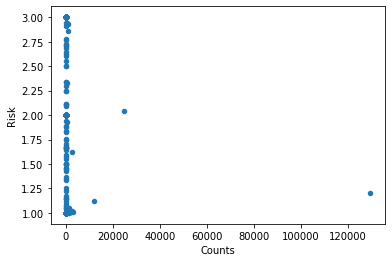

In [117]:
# Perform inner merge on number of facilities and their risk scores 
merged_inner = pd.merge(left=fac_dist,right=grouped_fac_risk_mean,left_on='Facility Type',right_on='Facility Type')
# Scatter plot: number of facilities in each type (i.e. facility type) vs. average risk score
merged_inner.plot.scatter(x='Counts',y='Risk')

We realized that the dataset is unbalanced in terms of number of Facility Types, where there are some Facility Types with very few instances. The types of facilities with very few instances would provide us with little to no information. Hence, we decided to analyze the 50 most frequent type of facilities and drop the others:

In [118]:
print("Number of entries before removing facility types with few instances: " + str(df.size))
df = df[df['Facility Type'].isin(list(fac_dist['Facility Type'])[:50])]
print("Number of entries after removing facility types with few instances: " + str(df.size))

Number of entries before removing facility types with few instances: 2523014
Number of entries after removing facility types with few instances: 2434458


As we can see from the code above, there are around 20 thousand facilities that dont have as much inspections as the others. As a result, data set is more balanced now

In [119]:
# Out of business facilities
df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob
# Grouped by the facilities
df_oob_unique = df_oob.groupby(['Latitude','Longitude','DBA Name']).count()
df_oob_unique.shape

(11689, 10)

We mapped the facilities that have gone out of business to identify any possible pattern:

In [0]:
# Map the facilities that have gone out of business 
map_oob = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

marker_cluster = MarkerCluster().add_to(map_oob)
ranges = 0
for i in df_oob_unique.index:
    if ranges == 3000:
        break
    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)        
    ranges = ranges + 1

map_oob

In [0]:
# Calculate risk mean of each facility
df_avg_risk_score = df.groupby(['Latitude','Longitude','DBA Name'])['Risk'].mean()

We mapped the average risk score of facilities to identify any possible pattern:

In [0]:
# Map the average risk score of facilities, where red indicates high risk, orange indicates medium risk, and green indicates low risk
map_risk = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

ranges = 0
for i in df_avg_risk_score.index:
    if ranges == 1000:
        break
    if(round(df_avg_risk_score[i]) == 1):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 2):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 3):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green')).add_to(map_risk)       
    ranges = ranges + 1

map_risk

We plotted the number of inspections vs. the average risk score of each facility to identify any possible correlation between the two. We observed the there is a negative correlation between the number of inspections and the average risk of the facility:

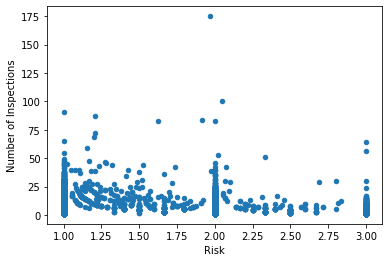

In [131]:
# Scatter plot on the number of inspections vs. the average risk score
df_unique = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count()['Risk']).rename(columns={'Risk':'Number of Inspections'})
merged = pd.merge(left=df_avg_risk_score.reset_index(),right=df_unique.reset_index(),left_on=['Latitude','Longitude','DBA Name'],right_on=['Latitude','Longitude','DBA Name'])
merged.plot.scatter(x='Risk', y='Number of Inspections')

In [124]:
#counts >= 5 olacak şekilde yapılcak
#BUNDA CORRELATİIN GÖRMEDİK
#INSPECTION COUNTU FAZLA OLANLARI ALDIK
'''
df_u_sorted = df_unique.sort_values(by='Counts',ascending=False).reset_index().head(1100)
df_u_sorted[df_u_sorted['Counts'].isin(list(df_u_sorted['Counts'])[:1100])]
merged = pd.merge(left=df_avg_risk_score.reset_index(),right=df_u_sorted,left_on=['Latitude','Longitude','DBA Name'],right_on=['Latitude','Longitude','DBA Name'])
merged
merged.plot.scatter(x='Risk',y='Counts')
'''

"\ndf_u_sorted = df_unique.sort_values(by='Counts',ascending=False).reset_index().head(1100)\ndf_u_sorted[df_u_sorted['Counts'].isin(list(df_u_sorted['Counts'])[:1100])]\nmerged = pd.merge(left=df_avg_risk_score.reset_index(),right=df_u_sorted,left_on=['Latitude','Longitude','DBA Name'],right_on=['Latitude','Longitude','DBA Name'])\nmerged\nmerged.plot.scatter(x='Risk',y='Counts')\n"

We observed that the number of risk 3 facilities are lower than the others. Hence, we decided to plot average risk scores vs number of facilities.

We observed a moderate positive correlation between the number of inspections and average level of risk of the facility (since Risk 1 means high risk and Risk 3 means low risk):

In [125]:
merged[['Risk', 'Counts']].corr(method='pearson')

,Risk,Counts
Risk,1.000000,-0.376107
Counts,-0.376107,1.000000


In [126]:
# Grouped by risk scores and number of facilities
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score).apply(lambda x: round(x)).reset_index()
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score1.groupby('Risk').count()['Latitude']).rename(columns={'Latitude':'Counts'})
df_avg_risk_score1

,Counts
Risk,
1.0,15735
2.0,6840
3.0,4303


<BarContainer object of 3 artists>

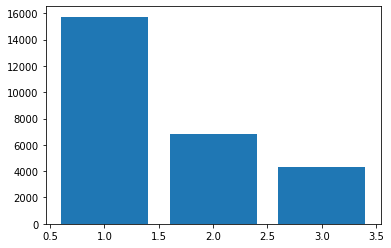

In [127]:
plt.bar(df_avg_risk_score1.index,df_avg_risk_score1['Counts'])